# Best Actor - Mobile Game about Facial Expression based on Convolutional Neural Network

## Abstract

TODO

## Terminology

TODO

## UI & UX Design

TODO

## Technical Design

TODO

## Code Implementation

### Part 1: Computer Vision

#### **Preprocess Data**

First and foremost, we need to preprocess the dataset. Here I use **FER2013** dataset for the facial expression recognition, which contains 7 categories in total, including (1) Angry, (2) Disgust, (3) Fear, (4) Happy, (5) Neutral, (6) Sad and (7) Surprise. The examples of FER2013 dataset are illustrated as follows.

![Facial Expressions](https://drive.google.com/uc?id=11VQZQZLD0_GwkcR4vUWTNtBdbbZS0Dh7)

The dataset has the following advantages:
- It contains dataset with various ages
![age](https://drive.google.com/uc?id=1mUcafNru8bb6pn-6xFkW74qIQVpI9Jyh)
- It contains dataset with different ethics
![ethic](https://drive.google.com/uc?id=1bZf1BR-fVZvnHmlgT-ZDbJKRQULxfOJ7)
- It contains dataset with accessories
![accessory](https://drive.google.com/uc?id=1xmEbRDzKBeDRpGa63hGH-kIBOGMXMJJp)

However, the dataset also has the following disadvantages:
- Some images have watermark, which might have potential copyright issue
![watermark](https://drive.google.com/uc?id=142nfQZ3a1hMdFhQIr2-V3wmxBEvYFDhz)
- Some images are cartoon characters
![cartoon](https://drive.google.com/uc?id=1UTUDU5ac8aTcfR9O7WTqDUkGgj-1RfkJ)
- Some images have inconsistent facial expressions and labels. For example, the following facial expressions are marked as "Happy" in FER2013 dataset, which are apparently not "Happy" facial expressions
![inconsistent](https://drive.google.com/uc?id=1Gu0SNL7B3uoQ7TEmv1LRe3-97NCET9iX)
- Some images are broken and have no facial expressions
![non-people](https://drive.google.com/uc?id=1sbeWG41IOot29GOY6iCAwRQPG71-Euhk)
- Some images have multiple faces
![many](https://drive.google.com/uc?id=1l8PPTBHb7BPS7LukOAdVV0yM1ZaBSAlQ)

Therefore, I preprocessed the dataset by removing ineligible images. Then, I created the preprocessed "train.csv" with the following function.
```python
from PIL import Image
import os
import imghdr
import numpy
import csv

# Constants
TRAINING_DATA_DIRECTORY = 'TrainingDataSelected/'
TRAIN_CSV_FILE = 'train.csv'
TRAIN_CSV_WRITE_MODE = 'w'
TRAIN_DATA_IMAGE_TYPE = 'jpeg'

FACIAL_EXPRESSION_LABELS = {
    'Happy': '0',
    'Sad': '1',
    'Surprise': '2'
}

class Preprocessor:

    def preprocess_data(self):
        """Preprocess facial expression dataset.
        This function will save training data to train.csv in the directory.
        train.csv contains two columns:
        - Facial expression label
        - Numpy array of facial expression image file (48 x 48)
        """
        with open(TRAIN_CSV_FILE, mode=TRAIN_CSV_WRITE_MODE) as train:

            # Create train writer
            train_writer = csv.writer(train)

            # Iterate through training image data
            with os.scandir(TRAINING_DATA_DIRECTORY) as entries:

                for entry in entries:
                    path = entry.path
                    file_type = imghdr.what(path)

                    if file_type == TRAIN_DATA_IMAGE_TYPE:

                        # Label
                        name = entry.name
                        facial_expression_name = name.split('_')[0]
                        label = FACIAL_EXPRESSION_LABELS[facial_expression_name]

                        # Image file
                        image_file = Image.open(path)
                        image = numpy.array(image_file)
                        pixels = '-'.join(map(str, image.flat))

                        # Write to CSV file
                        row = [label, pixels]
                        train_writer.writerow(row)

# Preprocess data
preprocessor = Preprocessor()
preprocessor.preprocess_data()
```

#### **Load Data**

After preprocessed the data, the "train.csv" has been uploaded to Google Drive. Then, use the following function to download the dataset.

In [0]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1nN7LOW50ZpLAJ7tb6w6_OuOgpWv1rOV1' -O train.csv > /dev/null 2>&1

Here, we need to load the dataset with the following function.

In [0]:
import csv
import numpy

# Constants
TRAIN_DATA_FILE = 'train.csv'

class DataLoader:

    def load_train_data(self):
        """Load train dataset.
        This function will create numpy array of train images and labels.
        """
        images = []
        labels = []

        # Open train.csv file
        with open(TRAIN_DATA_FILE) as train_csv:

            # Read train.csv file
            csv_reader = csv.reader(train_csv)
            for row in csv_reader:

                pixels_str = row[1]
                pixels_list = [int(i) for i in pixels_str.split('-')]
                pixels_list = numpy.array(pixels_list, dtype='uint8')
                image = pixels_list.reshape((48, 48))

                label = int(row[0])

                images.append(image)
                labels.append(label)

        # Create numpy array of train images and labels
        x_train = numpy.array(images)
        y_train = numpy.array(labels)

        return (x_train, y_train)

Then, load the train data.

In [0]:
# Load data
data_loader = DataLoader()
x_train, y_train = data_loader.load_train_data()

And show one of the training images.

x_train shape: (9000, 48, 48)
y_train shape: (9000,)
Label is: 0


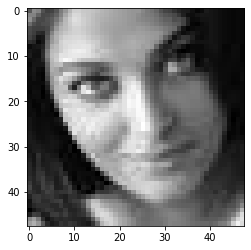

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

print('x_train shape: {0}'.format(x_train.shape))
print('y_train shape: {0}'.format(y_train.shape))

image = x_train[0]
label = y_train[0]

print('Label is: ' + str(label))
plt.imshow(image, cmap='gray')

#### **Tune Hyperparameter**

Then I use **Keras Tuner** to adjust hyperparameters of the model.

First of all, we need to install the Keras Tuner package.

In [0]:
!pip install -U keras-tuner > /dev/null 2>&1

Then, create the model to tune hyperparameter with the following functions.

In [6]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation
from kerastuner import HyperModel

class TunerHyperModel(HyperModel):

    def __init__(self,
                 input_shape,
                 output_filters,
                 min_conv_filters, 
                 max_conv_filters, 
                 conv_filters_steps, 
                 min_conv_layers,
                 max_conv_layers,
                 kernal_size=(3, 3)):
        """Initialize tuner hyper model class"""
        self.input_shape = input_shape # Input dimension shape
        self.output_filters = output_filters # Output how many categories
        self.min_conv_filters = min_conv_filters # Minimum convolutionary filters
        self.max_conv_filters = max_conv_filters # Maximum convolutionary filters
        self.conv_filters_steps = conv_filters_steps # Increasig steps
        self.min_conv_layers = min_conv_layers # Minimum convolutionary layers
        self.max_conv_layers = max_conv_layers # Maximum convolutionary layers
        self.kernal_size = kernal_size # Kernal size of convolutionary layer

    def build(self, hp):
        """Build hyper model to tune hyperparameter"""
        model = Sequential()
        
        # Add the first convolutionary layer with input shape
        model.add(Conv2D(hp.Int('input_units',
                                min_value=self.min_conv_filters,
                                max_value=self.max_conv_filters,
                                step=self.conv_filters_steps), 
                         kernel_size=self.kernal_size, 
                         input_shape=self.input_shape))
        model.add(Activation('relu'))
        model.add(MaxPooling2D())
        model.add(Dropout(hp.Choice('dropout',
                                    values=[0.3, 0.5])))

        # Add the variants of convolutionary layers
        for i in range(hp.Int('n_layers', self.min_conv_layers, self.max_conv_layers)):
            model.add(Conv2D(hp.Int(f'conv_{i}_units',
                                    min_value=self.min_conv_filters,
                                    max_value=self.max_conv_filters,
                                    step=self.conv_filters_steps),
                             kernel_size=self.kernal_size))
            model.add(Activation('relu'))
            model.add(MaxPooling2D())
            model.add(Dropout(hp.Choice('dropout',
                                    values=[0.3, 0.5])))

        # Add the final output layer
        model.add(Flatten()) 
        model.add(Dense(self.output_filters))
        model.add(Activation("softmax"))

        # Compile the model
        model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
        
        return model

TensorFlow 2.x selected.


Create folder with the output details when tuning the hyperparameter.

In [7]:
from google.colab import drive
import os

os.chdir('/content/sample_data/')

!pwd
!rm -rf ./hparams

OUTPUT_DIR = './hparams/'
os.makedirs(OUTPUT_DIR)

/content/sample_data


Now we create the train dataset and test dataset, and tune the hyperparameter. Here I use **Hyper Band** and **Early Stopping** to tune the hyperparameter.

In [8]:
from kerastuner.tuners import Hyperband
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Constants
INPUT_SHAPE = (48, 48, 1)
OUTPUT_FILTERS = 3

MIN_CONV_FILTERS = 32
MAX_CONV_FILTERS = 128
CONV_FILTERS_STEPS = 32
MIN_CONV_LAYERS = 1
MAX_CONV_LAYERS = 2

HYPERPARAMETER_EPOCHS = 6
MAX_EPOCHS = 6
OBJECTIVE_VAL_ACCURACY = 'val_accuracy'
PROJECT_NAME = 'BestActor'

# Split dataset into 80% for train and 20% for test
hp_x_train, hp_x_test, hp_y_train, hp_y_test = train_test_split(x_train, y_train, test_size=0.2)
hp_x_train, hp_x_test = hp_x_train / 255.0, hp_x_test / 255.0

hp_x_train = hp_x_train.reshape(len(hp_x_train), 48, 48, 1)
hp_x_test = hp_x_test.reshape(len(hp_x_test), 48, 48, 1)

print(hp_x_train.shape)
print(hp_x_test.shape)

# Create tuner hyper model
tuner_model = TunerHyperModel(INPUT_SHAPE, OUTPUT_FILTERS,
                              MIN_CONV_FILTERS, MAX_CONV_FILTERS, CONV_FILTERS_STEPS,
                              MIN_CONV_LAYERS, MAX_CONV_LAYERS)

# Create using hyper band
tuner = Hyperband(tuner_model, 
                  objective=OBJECTIVE_VAL_ACCURACY,
                  max_epochs=HYPERPARAMETER_EPOCHS,
                  directory=OUTPUT_DIR,
                  project_name=PROJECT_NAME)

# Summary tuner
tuner.search_space_summary()

# Fine tune hyperparameter
tuner.search(x=hp_x_train,
             y=hp_y_train,
             epochs=MAX_EPOCHS,
             verbose=0,
             validation_data=(hp_x_test, hp_y_test),
             callbacks=[EarlyStopping(patience=3)]) # Early stopping strategy

(7200, 48, 48, 1)
(1800, 48, 48, 1)


INFO:tensorflow:Oracle triggered exit


After tuning the hyperparameter, we print out the best hyperparameter.

In [9]:
tuner.get_best_hyperparameters()[0].values

{'conv_0_units': 96,
 'conv_1_units': 128,
 'dropout': 0.3,
 'input_units': 32,
 'n_layers': 1,
 'tuner/bracket': 0,
 'tuner/epochs': 6,
 'tuner/initial_epoch': 0,
 'tuner/round': 0}

Finally, summarize the best model with the fine-tuned hyperparameter.

In [10]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 46, 46, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 96)        27744     
_________________________________________________________________
activation_1 (Activation)    (None, 21, 21, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 96)        0

#### **Train Data**

Then I use **K-Fold Cross Validation** to prepare training set and test set.

K-Fold Trial: 1, Best accuracy: 0.9269135594367981, Best validation accuracy: 0.8600000143051147
K-Fold Trial: 2, Best accuracy: 0.9298765659332275, Best validation accuracy: 0.9722222089767456
K-Fold Trial: 3, Best accuracy: 0.9419752955436707, Best validation accuracy: 0.9877777695655823
K-Fold Trial: 4, Best accuracy: 0.9511111378669739, Best validation accuracy: 0.9855555295944214
K-Fold Trial: 5, Best accuracy: 0.9528394937515259, Best validation accuracy: 0.9911110997200012
K-Fold Trial: 6, Best accuracy: 0.9586419463157654, Best validation accuracy: 0.9977777600288391
K-Fold Trial: 7, Best accuracy: 0.9595061540603638, Best validation accuracy: 0.996666669845581
K-Fold Trial: 8, Best accuracy: 0.9630864262580872, Best validation accuracy: 0.9988889098167419
K-Fold Trial: 9, Best accuracy: 0.9649382829666138, Best validation accuracy: 0.9977777600288391
K-Fold Trial: 10, Best accuracy: 0.9656789898872375, Best validation accuracy: 0.9977777600288391


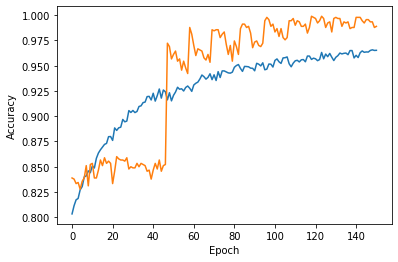

In [11]:
from sklearn.model_selection import StratifiedKFold

# Constants
K_FOLD_SPLIT = 10 # Split to 10 folds for cross validation
BATCH_SIZE = 100
EPOCHS = 100

# Define Stratigied K-Fold with split
kfold = StratifiedKFold(n_splits=K_FOLD_SPLIT)

trial_num = 0
x_train = x_train / 255.0
x_train = x_train.reshape(len(x_train), 48, 48, 1)

accuracy_history = []
val_accuracy_history = []

for train_indices, test_indices in kfold.split(x_train, y_train):

    # Prepare training set and test set
    kfold_x_train = x_train[train_indices]
    kfold_y_train = y_train[train_indices]
    kfold_x_test = x_train[test_indices]
    kfold_y_test = y_train[test_indices]

    # Train data
    history = model.fit(kfold_x_train,
                        kfold_y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        verbose=0,
                        validation_data = (kfold_x_test, kfold_y_test),
                        callbacks=[EarlyStopping(patience=10)]) # Early stopping strategy

    # Calculate accuracy history
    current_accuracy = history.history['accuracy']
    for accuracy in current_accuracy:
        accuracy_history.append(accuracy)

    current_val_accuracy = history.history['val_accuracy']
    for val_accuracy in current_val_accuracy:
        val_accuracy_history.append(val_accuracy)

    # Find the best score
    best_accuracy = max(current_accuracy)
    best_val_accuracy = max(current_val_accuracy)

    # Show some logs 
    trial_num += 1
    print('K-Fold Trial: {}, Best accuracy: {}, Best validation accuracy: {}'.format(trial_num, best_accuracy, best_val_accuracy))

# Show diagram
plt.plot(accuracy_history, label='accuracy')
plt.plot(val_accuracy_history, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#### **Evaluate Model**

TODO

#### **Export Model**

TODO

#### **Convert CoreML Model**

TODO

### Part 2: Mobile Game

#### **Crop ROI with OpenCV**

TODO

#### **Predict using CoreML Model**

TODO

## Video Demonstration

TODO

## Conclusion

TODO

## Reference

TODO